# Tutorial: How to load and use the datasets generated by detect.py

In [1]:
import sys
sys.path.append("../")
from PathFindRNET.dataset.dataset_loader import load_dataset

In [2]:
# The path to the joblib file
# this can be a file or a directory containing multiple joblib files
# NOTE: if directory path is given, the joblib files get concatenated
# so it is recommended to use the directory path option only if the 
# datasets are from the same source
# dataset_path = "/media/pecneb/970evoplus/tavaszi_szel_konferencia_datasets/Bellevue_116th_NE12th_24H"
# dataset_path = "/media/pecneb/970evoplus/gitclones/computer_vision_research/research_data/short_test_videos"
# dataset_path = "/media/pecneb/970evoplus/tavaszi_szel_konferencia_datasets/Bellevue_116th_NE12th_24H_PathFindRNET/Bellevue_116th_NE12th__2017-09-11_08-08-50.joblib"
dataset_path = "/media/pecneb/970evoplus/tavaszi_szel_konferencia_datasets/Bellevue_116th_NE12th_24H_PathFindRNET/"

## To load the dataset
- Use the load_dataset() function, which will return a numpy array with the TrackedObject instances
- To check the dataset is loaded correctly print out some of the objects, they have a representation string for debugging

In [3]:
dataset = load_dataset(dataset_path)
print(dataset[:11])

Loading datasets: 0it [00:00, ?it/s]

Loading datasets: 21it [00:46,  2.22s/it]


[ID: 47646, Label: person ID: 47647, Label: person
 ID: 47648, Label: person ID: 47649, Label: person
 ID: 47650, Label: person ID: 47651, Label: person
 ID: 47652, Label: person ID: 47653, Label: person
 ID: 47654, Label: person ID: 47655, Label: person
 ID: 47656, Label: person]


In [4]:
def stats(dataset):
    print(f"Number of trajectories in dataset: {len(dataset)}")
    object_labels = {traj.label for traj in dataset}
    print(f"Object labels: {object_labels}")
    history_lengths = [len(traj.history) for traj in dataset]
    max_history_length = max(history_lengths)
    min_history_length = min(history_lengths)
    print(f"Maximum history length: {max_history_length}")
    print(f"Minimum history length: {min_history_length}")
    avg_length = sum(history_lengths) / len(history_lengths)
    print(f"Average history length: {avg_length}")
    std = (sum([(x - avg_length) ** 2 for x in history_lengths]) / len(history_lengths)) ** 0.5
    print(f"Standard deviation of history lengths: {std}")
    return history_lengths, object_labels

history_lengths, object_labels = stats(dataset)

Number of trajectories in dataset: 71599
Object labels: {'car', 'bicycle', 'motorcycle', 'bus', 'person', 'truck'}
Maximum history length: 4241
Minimum history length: 2
Average history length: 31.123521278230143
Standard deviation of history lengths: 141.34088794012172


## Visualize the unfiltered dataset by using matplotlib

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme()

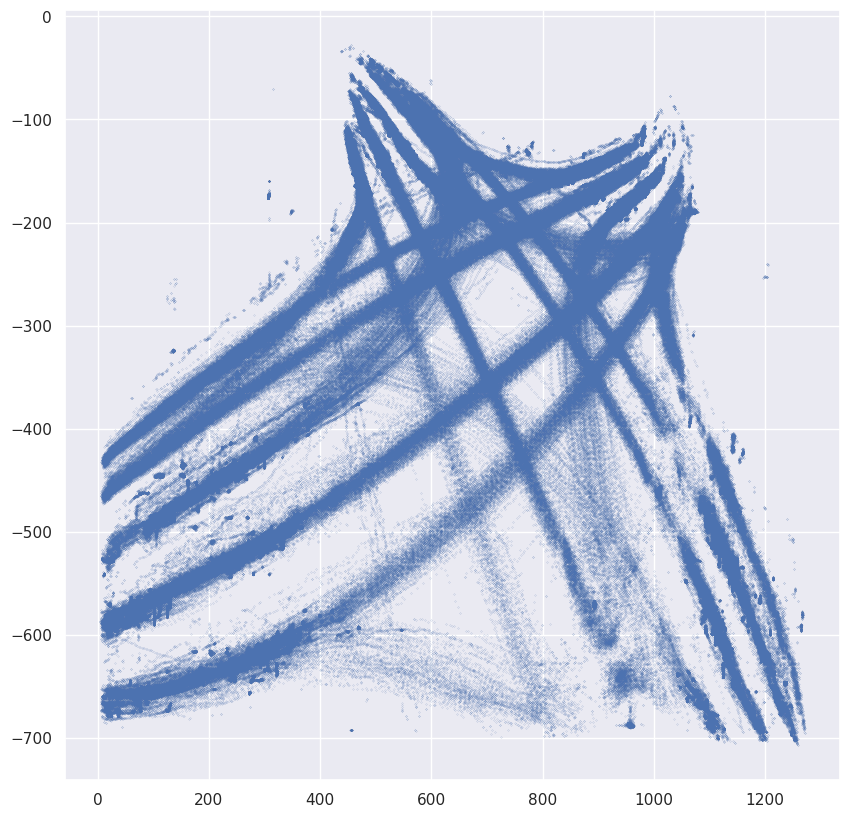

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
X = np.concatenate([o.history_X for o in dataset])
Y = 1 - np.concatenate([o.history_Y for o in dataset])
ax.scatter(x=X, y=Y, s=0.01)

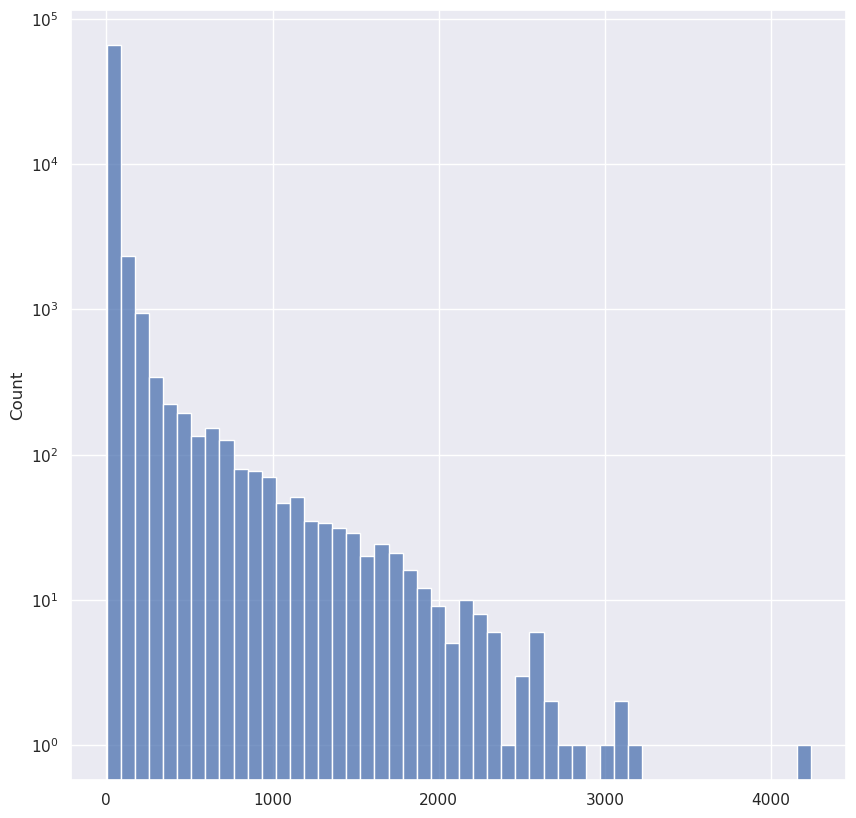

In [7]:
# Plot histogram of history lengths with seaborn (log scale)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot(history_lengths, ax=ax, bins=50)
ax.set_yscale('log')

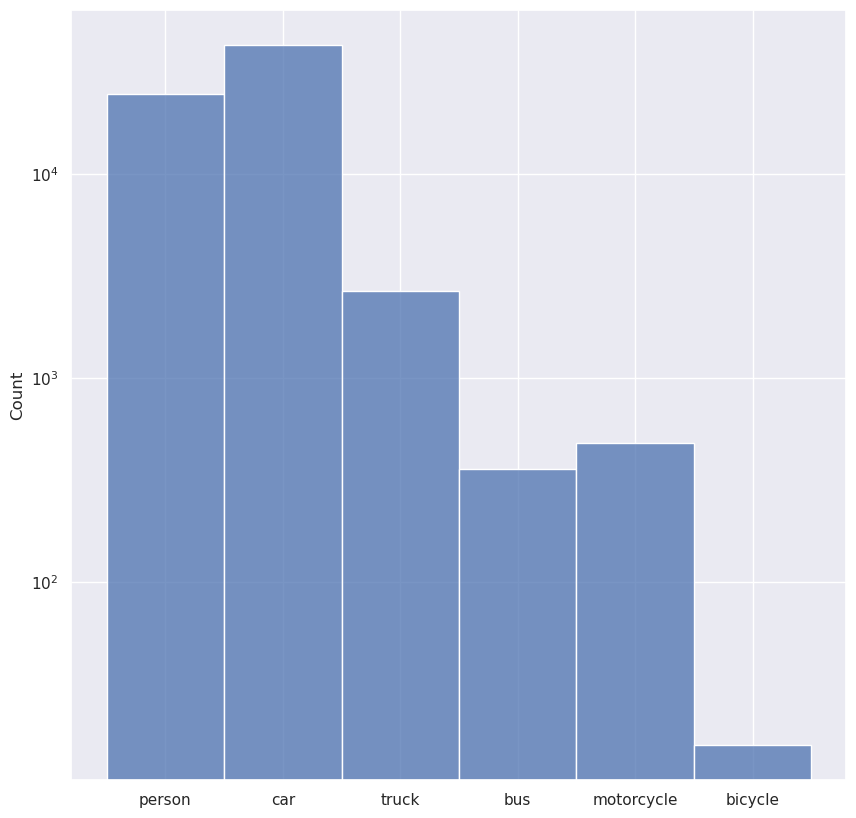

In [8]:
# Make historgram of object labels (log scale)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot([traj.label for traj in dataset], bins=len(object_labels))
ax.set_yscale('log')

## Apply filtering on dataset
- Filtering based on first and last detection distance from each other
- Filtering based on first and last detection distance from relative edges
- Filtering based on detections distance from each other 

In [9]:
from PathFindRNET.dataset.preprocess import (
    filter_out_false_positive_detections_by_enter_exit_distance,
    filter_out_noise_trajectories,
    filter_out_edge_detections,
    euclidean_distance,
    filter_trajectories
)

In [10]:
distances = [
    euclidean_distance(
        traj.history_X[0], traj.history_X[-1], traj.history_Y[0], traj.history_Y[-1]
    )
    for traj in dataset
]
max_distance = max(distances)
min_distance = min(distances)
print(f"Maximum distance between start and end points: {max_distance}")
print(f"Minimum distance between start and end points: {min_distance}")
filtered_1 = filter_out_false_positive_detections_by_enter_exit_distance(dataset, 1000)
distances = [
    euclidean_distance(
        traj.history_X[0], traj.history_X[-1], traj.history_Y[0], traj.history_Y[-1]
    )
    for traj in filtered_1 
]
max_distance = max(distances)
min_distance = min(distances)
print(f"Maximum distance between start and end points: {max_distance}")
print(f"Minimum distance between start and end points: {min_distance}")

Maximum distance between start and end points: 1160.841612796509
Minimum distance between start and end points: 0.0
Maximum distance between start and end points: 1160.841612796509
Minimum distance between start and end points: 1000.296206130964


In [11]:
history_lengths_filtered_1, object_labels = stats(filtered_1)

Number of trajectories in dataset: 528
Object labels: {'car', 'motorcycle', 'truck'}
Maximum history length: 2523
Minimum history length: 54
Average history length: 453.405303030303
Standard deviation of history lengths: 430.3055452171226


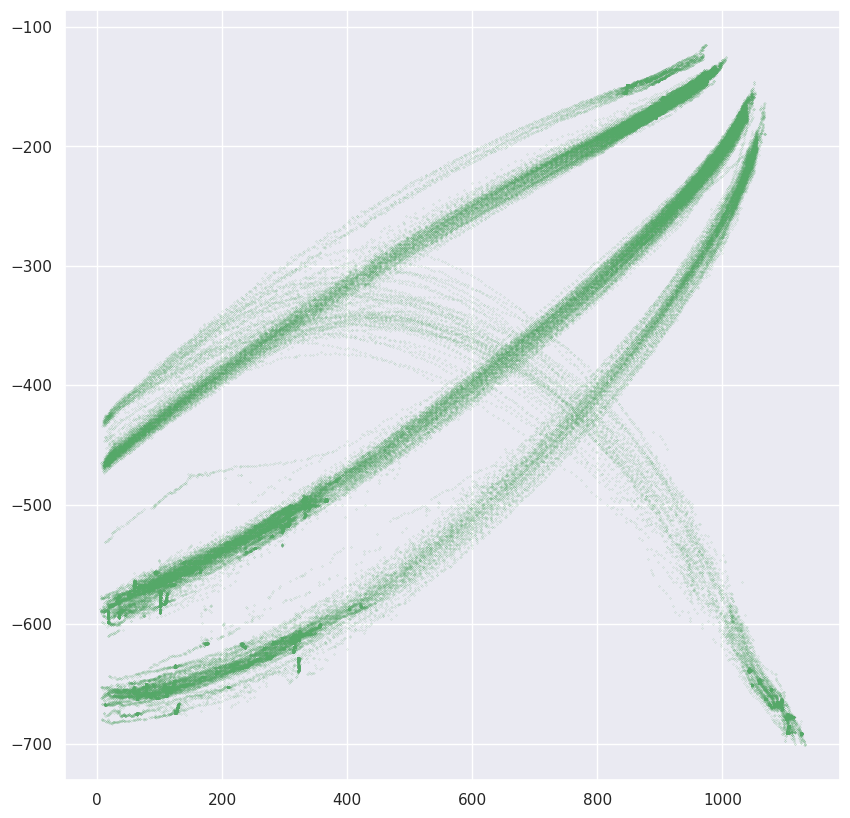

In [12]:
# scatter plot of filtered trajectories
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
x = np.concatenate([o.history_X for o in filtered_1])
y = 1 - np.concatenate([o.history_Y for o in filtered_1])
ax.scatter(x=x, y=y, s=0.01, c='g')

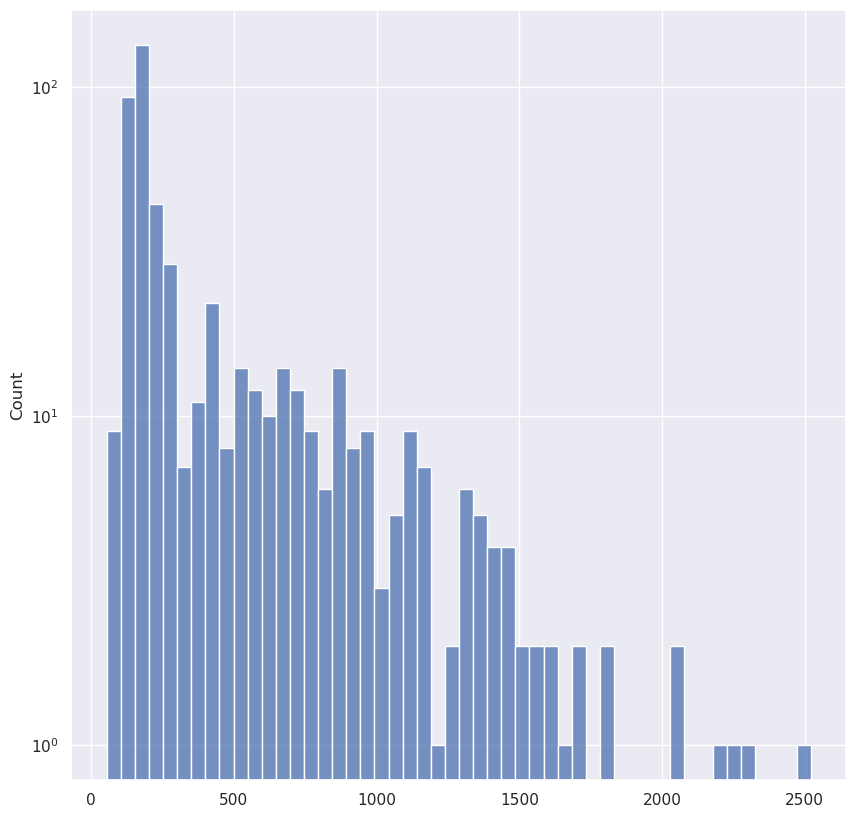

In [13]:
# Plot histogram of history lengths with seaborn (log scale)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot(history_lengths_filtered_1, ax=ax, bins=50)
ax.set_yscale('log')

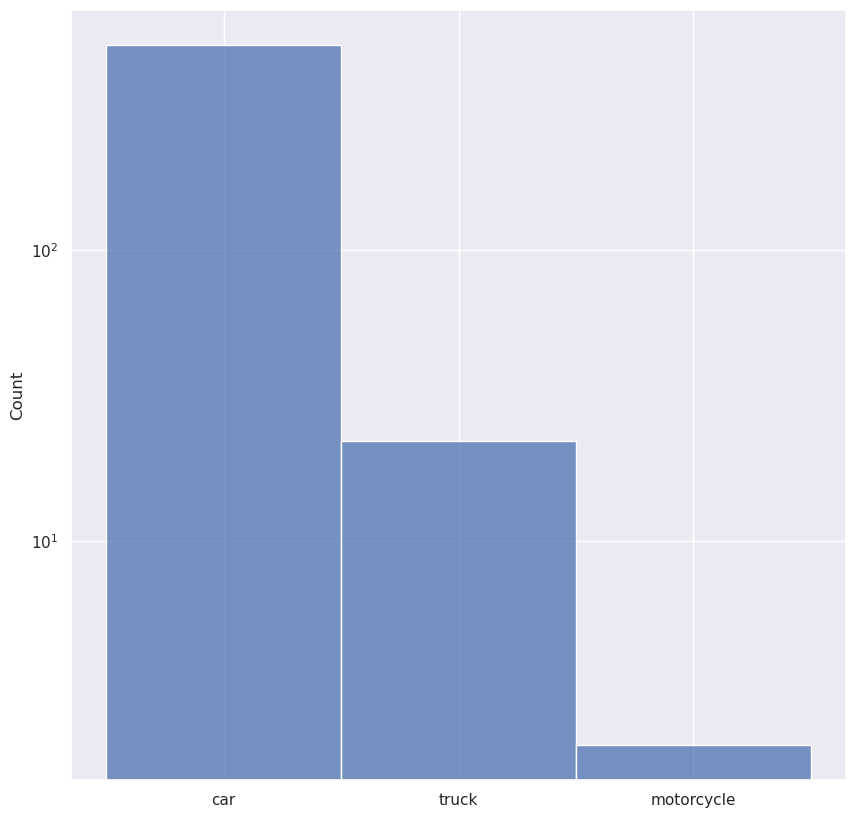

In [14]:
# Make historgram of object labels (log scale)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot([traj.label for traj in filtered_1], bins=len(object_labels))
ax.set_yscale('log')

## Filter by detection count / trajectory length

In [15]:
from PathFindRNET.dataset.trajectory import TrackedObject, Detection
from itertools import filterfalse
from typing import Tuple, List

def filter_by_length(trajectory: List[TrackedObject], length_threshold: int) -> List[TrackedObject]:
    """Filter trajectories by length / number of detections.

    Parameters
    ----------
    trajectory : List[TrackedObject]
        Trajectories to filter.

    Returns
    -------
    List[TrackedObject]
        List of filtered trajectories
    """
    return list(
        filterfalse(
            lambda x: x.history_X.shape[0] < length_threshold, trajectory))

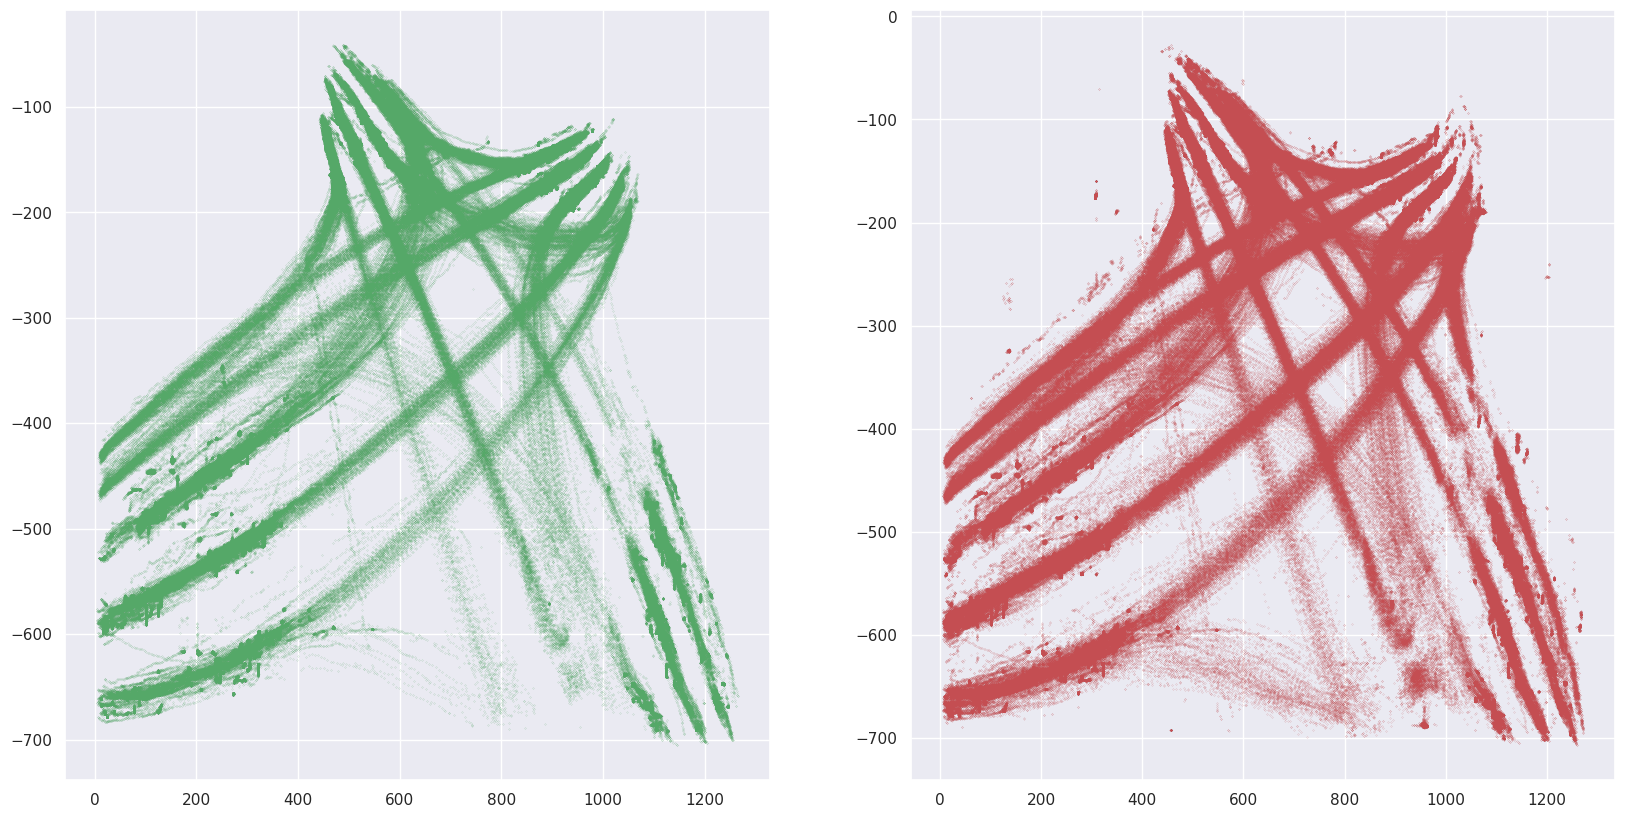

In [16]:
filtered_2 = filter_by_length(dataset, 200)
# Scatter plot of filtered trajectories
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
X = np.concatenate([o.history_X for o in filtered_2])
Y = 1 - np.concatenate([o.history_Y for o in filtered_2])
ax[0].scatter(x=X, y=Y, s=0.01, c='g')
X_orig = np.concatenate([o.history_X for o in dataset])
Y_orig = 1 - np.concatenate([o.history_Y for o in dataset])
ax[1].scatter(x=X_orig, y=Y_orig, s=0.01, c='r')

## Filling and Ironing trajectories

In [17]:
from scipy.ndimage import median_filter
import tqdm
from copy import deepcopy

def fill_trajectory(trajectory_orig: TrackedObject) -> TrackedObject:
    """Fill noisy trajectory, which has haps in detections. 
    """
    trajectory = deepcopy(trajectory_orig)
    X = trajectory.history_X.copy() # np.array([d.X for d in trajectory.history])
    Y = trajectory.history_Y.copy() # np.array([d.Y for d in trajectory.history])
    frame_id_list = [d.frameID for d in trajectory.history]
    width = np.array([d.Width for d in trajectory.history])
    height = np.array([d.Height for d in trajectory.history])
    bbox_points = np.zeros((len(width), 4))
    bbox_points[:, 0] = X - (width / 2)
    bbox_points[:, 1] = Y - (height / 2)
    bbox_points[:, 2] = X + (width / 2)
    bbox_points[:, 3] = Y + (height / 2)
    for i in range(4):
        bbox_points[:, i] = median_filter(bbox_points[:, i], size=20)
    X_new = (bbox_points[:, 0] + bbox_points[:, 2]) / 2
    Y_new = (bbox_points[:, 1] + bbox_points[:, 3]) / 2
    for i in range(len(trajectory.history)):
        trajectory.history[i].Width = bbox_points[i, 2] - bbox_points[i, 0]
        trajectory.history[i].Height = bbox_points[i, 3] - bbox_points[i, 1]
    frame_id_list_full = list(range(frame_id_list[0], frame_id_list[-1] + 1))
    trajectory.history_X = np.interp(frame_id_list_full, frame_id_list, X_new)
    trajectory.history_Y = np.interp(frame_id_list_full, frame_id_list, Y_new)
    for i in range(len(frame_id_list_full)):
        if frame_id_list_full[i] not in frame_id_list:
            try:
                trajectory.history = (trajectory.history[:i] +
                    [Detection(label=trajectory.history[i-1].label, 
                            confidence=trajectory.history[i-1].confidence, 
                            frameID=frame_id_list_full[i], 
                            X=trajectory.history_X[i], 
                            Y=trajectory.history_Y[i], 
                            Width=trajectory.history[i-1].Width, 
                            Height=trajectory.history[i-1].Height
                    )] + trajectory.history[i:])
            except IndexError:
                print(f"Exception: {i}, {len(trajectory.history)}")
                break
    return trajectory
    

In [18]:
dataset = filter_trajectories(deepcopy(dataset), threshold=200, enter_exit_dist=1000, detectionDistanceFiltering=False)
filled_trajectories = [fill_trajectory(traj) for traj in dataset]

Filter out edge detections.: 100%|██████████| 71599/71599 [00:00<00:00, 175445.20it/s]


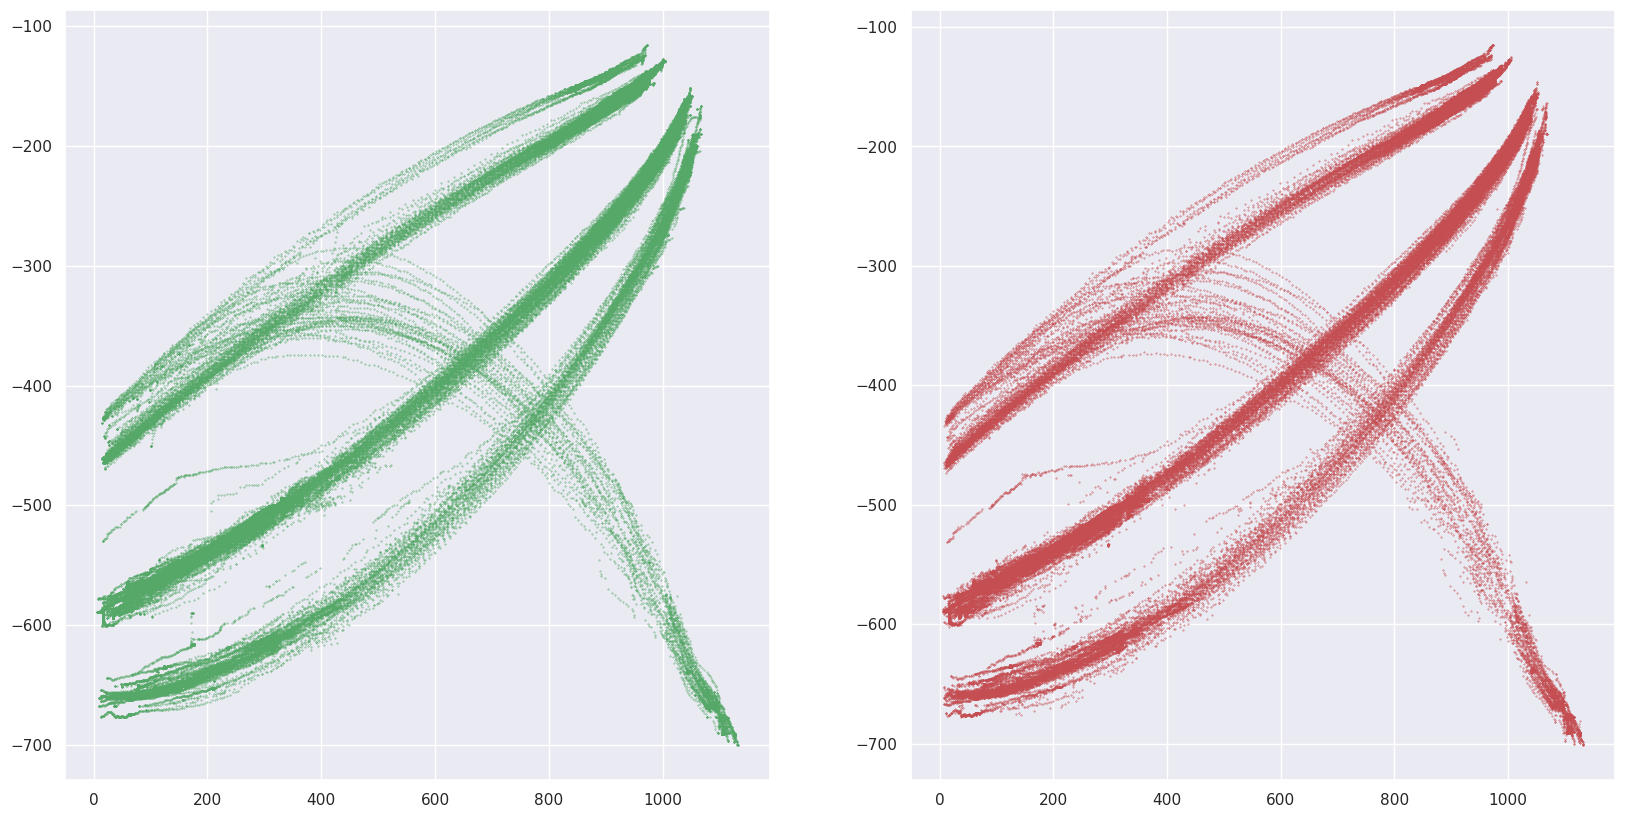

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
X = np.concatenate([filled_trajectories[i].history_X for i in range(len(filled_trajectories)) if len(filled_trajectories[i].history_X) > len(dataset[i].history_X)])
Y = 1 - np.concatenate([filled_trajectories[i].history_Y for i in range(len(filled_trajectories)) if len(filled_trajectories[i].history_Y) > len(dataset[i].history_Y)])
ax[0].scatter(x=X, y=Y, s=0.1, c='g')
X_orig = np.concatenate([dataset[i].history_X for i in range(len(filled_trajectories)) if len(filled_trajectories[i].history_X) > len(dataset[i].history_X)])
Y_orig = 1 - np.concatenate([dataset[i].history_Y for i in range(len(filled_trajectories)) if len(filled_trajectories[i].history_Y) > len(dataset[i].history_Y)])
ax[1].scatter(x=X_orig, y=Y_orig, s=0.1, c='r')
